# Connectivity Graph: The Crystal's Skeleton

From 1.11j we discovered:
- 122 unique vectors in the core
- ALL have at least 1 lattice neighbor (1 ULP apart in some dimension)
- Mean ~4 neighbors, max 4 neighbors
- Packing fraction: 0.078%

This notebook:
- Build the neighbor graph (nodes = vectors, edges = 1-ULP neighbors)
- Compute graph properties (diameter, path lengths, connected components)
- Identify which dimensions actually vary (most of 2560 are probably constant)
- Visualize the graph structure

Questions:
- Is this a line? A tree? A mesh?
- How many hops to get from any vector to any other?
- What's the effective dimensionality of this structure?

## Parameters

In [3]:
# Paths
CORE_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.11i_core_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Visualization
DPI = 200
GRAPH_LAYOUT = 'spring'  # or 'kamada_kawai' for force-directed
NODE_SIZE_SCALE = 2  # Scale factor for population-based sizing

## Imports

In [4]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from collections import defaultdict

## Device Detection

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [6]:
# Load core cluster token IDs
core_data = load_file(CORE_TOKENS_PATH)
core_token_ids = core_data['cluster_token_ids'].to(device)

print(f'Loaded {len(core_token_ids)} core token IDs')

Loaded 2206 core token IDs


In [7]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f'Loaded gamma matrix: {W.shape}')
print(f'Precision: {W.dtype}')

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [8]:
# Extract core vectors
core_vectors = W[core_token_ids]

print(f'Extracted {core_vectors.shape[0]} vectors of dimension {core_vectors.shape[1]}')

Extracted 2206 vectors of dimension 2560


## Find Unique Vectors

In [9]:
# Find unique vectors (stay in bfloat16)
unique_vectors, inverse_indices = torch.unique(core_vectors.to('cpu'), dim=0, return_inverse=True)
unique_vectors = unique_vectors.to(device)
inverse_indices = inverse_indices.to(device)

populations = torch.bincount(inverse_indices)

print(f'Found {len(unique_vectors)} unique vectors')
print(f'Precision: {unique_vectors.dtype}')
print(f'Population range: {populations.min().item()} to {populations.max().item()}')

Found 122 unique vectors
Precision: torch.bfloat16
Population range: 1 to 814


## Helper Functions

In [10]:
def nextafter_bfloat16(x_bf16, direction):
    """Get the next bfloat16 value after x in the given direction."""
    x_f32 = x_bf16.to(torch.float32)
    x_bits = x_f32.view(torch.int32).item()
    
    if x_bits == 0:
        if direction > 0:
            return torch.tensor(2**(-133), dtype=torch.bfloat16)
        else:
            return torch.tensor(-2**(-133), dtype=torch.bfloat16)
    
    if direction > 0:
        if x_bits > 0:
            x_bits += (1 << 16)
        else:
            x_bits -= (1 << 16)
    else:
        if x_bits > 0:
            x_bits -= (1 << 16)
        else:
            x_bits += (1 << 16)
    
    x_next_f32 = torch.tensor(x_bits, dtype=torch.int32).view(torch.float32)
    x_next_bf16 = x_next_f32.to(torch.bfloat16)
    
    return x_next_bf16

def vec_to_hashable(vec_bf16):
    """Convert bfloat16 vector to hashable tuple using bit patterns."""
    return tuple(vec_bf16.view(torch.int16).numpy())

print('✓ Helper functions defined')

✓ Helper functions defined


## Build Neighbor Graph

In [11]:
print('Building connectivity graph...')
print()

unique_vectors_cpu = unique_vectors.cpu()
num_dims = unique_vectors.shape[1]

# Create mapping: tuple → vector index
tuple_to_idx = {}
for i in range(len(unique_vectors_cpu)):
    vec_tuple = vec_to_hashable(unique_vectors_cpu[i])
    tuple_to_idx[vec_tuple] = i

# Build adjacency list
edges = []

for vec_idx in tqdm(range(len(unique_vectors_cpu)), desc='Finding neighbors'):
    vec = unique_vectors_cpu[vec_idx].clone()
    
    # Check each dimension for neighbors
    for dim_idx in range(num_dims):
        original_val = vec[dim_idx]
        
        # Try +1 ULP
        vec[dim_idx] = nextafter_bfloat16(original_val, +1)
        vec_tuple = vec_to_hashable(vec)
        if vec_tuple in tuple_to_idx:
            neighbor_idx = tuple_to_idx[vec_tuple]
            if neighbor_idx != vec_idx:  # Don't add self-loops
                edges.append((vec_idx, neighbor_idx))
        
        # Try -1 ULP
        vec[dim_idx] = nextafter_bfloat16(original_val, -1)
        vec_tuple = vec_to_hashable(vec)
        if vec_tuple in tuple_to_idx:
            neighbor_idx = tuple_to_idx[vec_tuple]
            if neighbor_idx != vec_idx:
                edges.append((vec_idx, neighbor_idx))
        
        # Restore original
        vec[dim_idx] = original_val

print(f'\n✓ Found {len(edges)} directed edges')
print(f'  (Each undirected edge counted twice)')

Building connectivity graph...



Finding neighbors: 100%|██████████| 122/122 [00:42<00:00,  2.89it/s]


✓ Found 24 directed edges
  (Each undirected edge counted twice)


## Create NetworkX Graph

In [12]:
# Create undirected graph
G = nx.Graph()

# Add nodes with population as attribute
for i in range(len(unique_vectors)):
    G.add_node(i, population=populations[i].item())

# Add edges (automatically deduplicates for undirected graph)
G.add_edges_from(edges)

print(f'Graph created:')
print(f'  Nodes: {G.number_of_nodes()}')
print(f'  Edges: {G.number_of_edges()}')
print(f'  Avg degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}')

Graph created:
  Nodes: 122
  Edges: 24
  Avg degree: 0.39


In [13]:
# Sanity check
print('Graph sanity check:')
print(f'  Self-loops: {nx.number_of_selfloops(G)}')
print(f'  Isolated nodes: {nx.number_of_isolates(G)}')
print(f'  Nodes with degree 0: {sum(1 for n in G.nodes() if G.degree(n) == 0)}')

Graph sanity check:
  Self-loops: 0
  Isolated nodes: 97
  Nodes with degree 0: 97


## Graph Properties

In [14]:
print('='*70)
print('GRAPH TOPOLOGY')
print('='*70)
print()

# Connected components
n_components = nx.number_connected_components(G)
print(f'Connected components: {n_components}')

if n_components == 1:
    print('  ✓ Graph is fully connected')
    
    # Diameter (longest shortest path)
    diameter = nx.diameter(G)
    print(f'\nDiameter: {diameter} hops')
    print(f'  (Maximum distance between any two vectors)')
    
    # Average shortest path length
    avg_path_length = nx.average_shortest_path_length(G)
    print(f'\nAverage shortest path: {avg_path_length:.2f} hops')
    print(f'  (Mean distance between all pairs of vectors)')
    
    # Radius (minimum eccentricity)
    radius = nx.radius(G)
    print(f'\nRadius: {radius} hops')
    print(f'  (Distance from center to furthest node)')
    
    # Center nodes (nodes with eccentricity = radius)
    center = nx.center(G)
    print(f'\nCenter nodes: {len(center)}')
    if len(center) <= 5:
        for node in center:
            pop = G.nodes[node]['population']
            print(f'  Node {node}: {pop} tokens')
else:
    print(f'  ⚠ Graph has {n_components} disconnected components')
    component_sizes = [len(c) for c in nx.connected_components(G)]
    component_sizes.sort(reverse=True)
    print(f'  Component sizes: {component_sizes}')

print()
print('='*70)

GRAPH TOPOLOGY

Connected components: 100
  ⚠ Graph has 100 disconnected components
  Component sizes: [12, 7, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



## Degree Distribution

In [15]:
degrees = [G.degree(n) for n in G.nodes()]
degree_counts = defaultdict(int)
for d in degrees:
    degree_counts[d] += 1

print('Degree distribution:')
for degree in sorted(degree_counts.keys()):
    count = degree_counts[degree]
    print(f'  Degree {degree}: {count} nodes ({100*count/len(degrees):.1f}%)')

# Identify hubs (high-degree nodes)
max_degree = max(degrees)
hubs = [n for n in G.nodes() if G.degree(n) == max_degree]

print(f'\nHub nodes (degree {max_degree}):')
for hub in hubs:
    pop = G.nodes[hub]['population']
    print(f'  Node {hub}: {pop} tokens')

Degree distribution:
  Degree 0: 97 nodes (79.5%)
  Degree 1: 12 nodes (9.8%)
  Degree 2: 7 nodes (5.7%)
  Degree 3: 3 nodes (2.5%)
  Degree 4: 2 nodes (1.6%)
  Degree 5: 1 nodes (0.8%)

Hub nodes (degree 5):
  Node 76: 704 tokens


## Varying Dimensions Analysis

In [16]:
print('\nAnalyzing which dimensions actually vary...')
print()

# Count unique values per dimension
varying_dims = []
unique_vectors_f32 = unique_vectors.to(torch.float32).cpu().numpy()

for dim_idx in range(num_dims):
    values = unique_vectors_f32[:, dim_idx]
    n_unique = len(np.unique(values))
    if n_unique > 1:
        varying_dims.append((dim_idx, n_unique))

# Sort by diversity (most unique values first)
varying_dims.sort(key=lambda x: x[1], reverse=True)

print(f'Dimensions with variation: {len(varying_dims)} / {num_dims}')
print(f'Constant dimensions: {num_dims - len(varying_dims)}')
print()
print(f'Effective dimensionality: {len(varying_dims)}')
print(f'  (The cluster lives in a {len(varying_dims)}-dimensional subspace)')
print()

if len(varying_dims) <= 20:
    print('All varying dimensions:')
    for dim_idx, n_unique in varying_dims:
        print(f'  Dimension {dim_idx}: {n_unique} unique values')
else:
    print('Top 20 most diverse dimensions:')
    for dim_idx, n_unique in varying_dims[:20]:
        print(f'  Dimension {dim_idx}: {n_unique} unique values')


Analyzing which dimensions actually vary...

Dimensions with variation: 2179 / 2560
Constant dimensions: 381

Effective dimensionality: 2179
  (The cluster lives in a 2179-dimensional subspace)

Top 20 most diverse dimensions:
  Dimension 1382: 82 unique values
  Dimension 1008: 76 unique values
  Dimension 1435: 67 unique values
  Dimension 1718: 64 unique values
  Dimension 1362: 57 unique values
  Dimension 727: 51 unique values
  Dimension 1662: 48 unique values
  Dimension 1207: 47 unique values
  Dimension 573: 45 unique values
  Dimension 1511: 44 unique values
  Dimension 2256: 43 unique values
  Dimension 413: 39 unique values
  Dimension 733: 37 unique values
  Dimension 1149: 37 unique values
  Dimension 2064: 37 unique values
  Dimension 2079: 36 unique values
  Dimension 2449: 35 unique values
  Dimension 1613: 34 unique values
  Dimension 1836: 33 unique values
  Dimension 2321: 33 unique values


## Graph Visualization

In [17]:
print(f'\nGenerating graph layout ({GRAPH_LAYOUT})...')

# Choose layout algorithm
if GRAPH_LAYOUT == 'spring':
    pos = nx.spring_layout(G, seed=42, iterations=50)
elif GRAPH_LAYOUT == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(G)
else:
    pos = nx.spring_layout(G, seed=42)

print('✓ Layout computed')


Generating graph layout (spring)...
✓ Layout computed


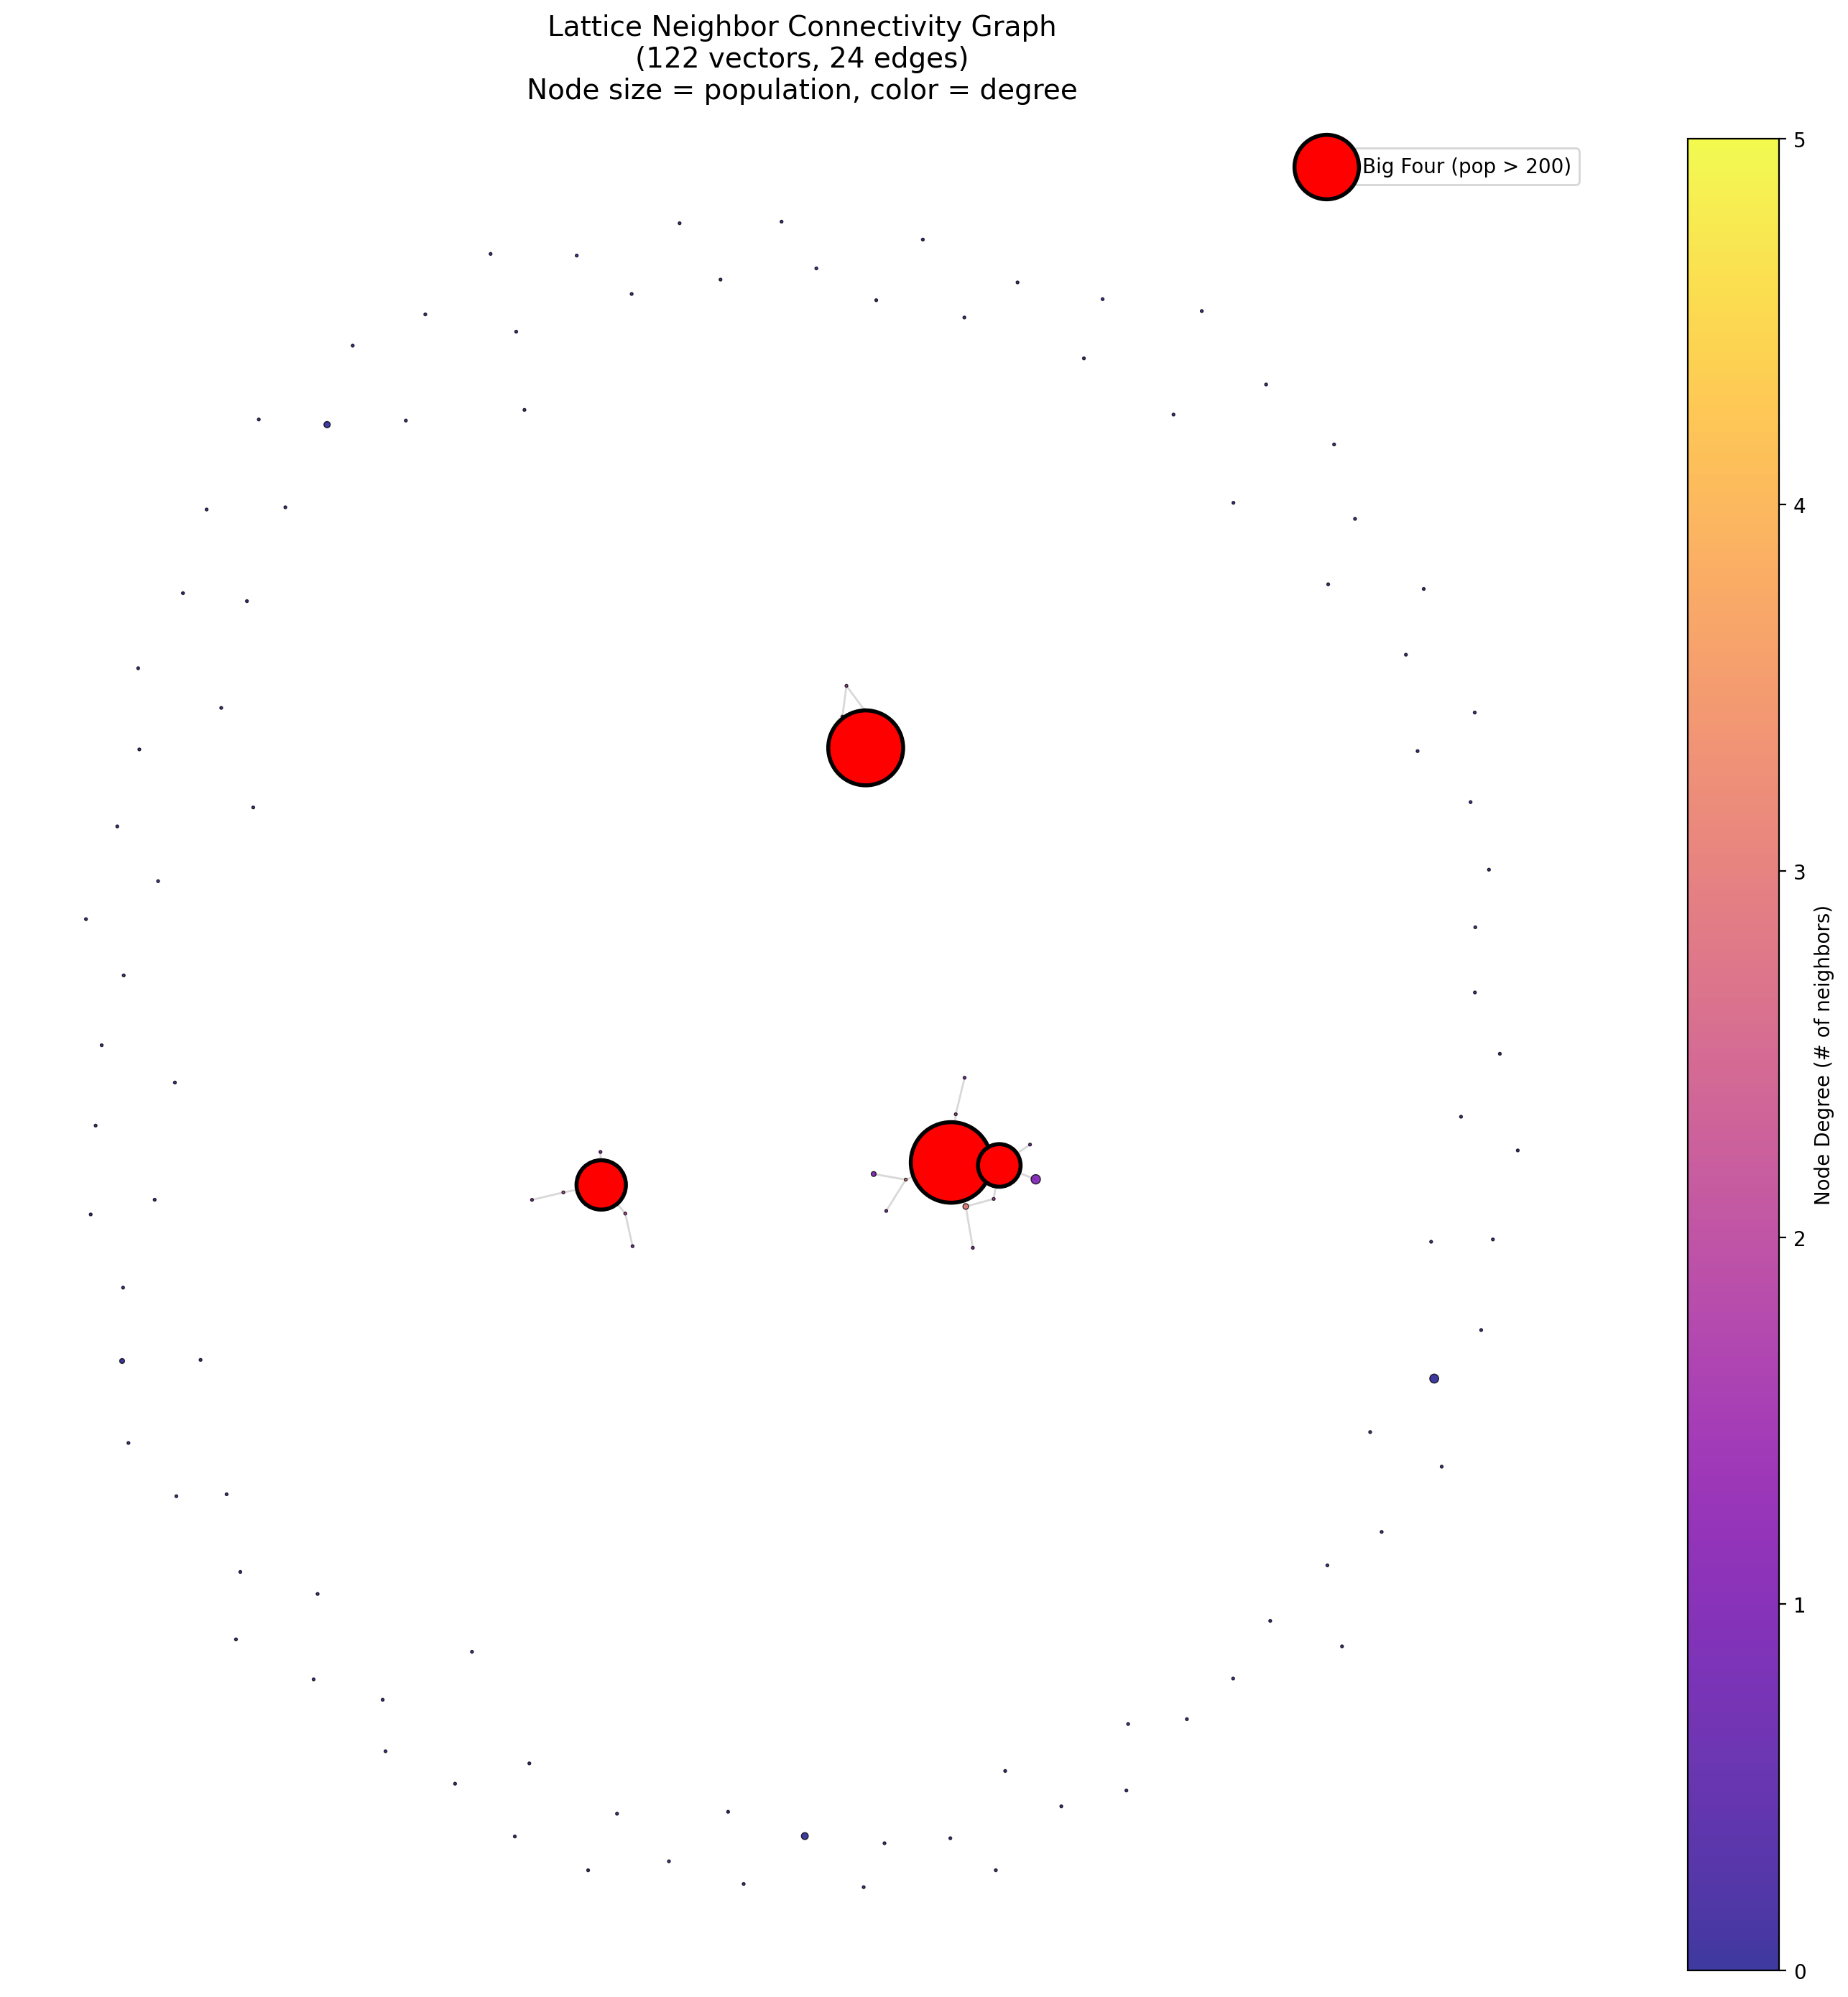

In [18]:
# Size nodes by population
node_sizes = [NODE_SIZE_SCALE * G.nodes[n]['population'] for n in G.nodes()]

# Color nodes by degree (connectivity)
node_colors = [G.degree(n) for n in G.nodes()]

fig, ax = plt.subplots(figsize=(14, 14), dpi=DPI)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray', ax=ax)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, pos, 
    node_size=node_sizes,
    node_color=node_colors,
    cmap='plasma',
    alpha=0.8,
    edgecolors='black',
    linewidths=0.5,
    ax=ax
)

# Colorbar
cbar = plt.colorbar(nodes, ax=ax)
cbar.set_label('Node Degree (# of neighbors)', color='black')

# Highlight the Big Four
big_four_indices = []
for i, pop in enumerate(populations):
    if pop >= 200:  # 814, 704, 306, 228
        big_four_indices.append(i)

if big_four_indices:
    big_four_pos = {i: pos[i] for i in big_four_indices}
    nx.draw_networkx_nodes(
        G, big_four_pos,
        nodelist=big_four_indices,
        node_size=[NODE_SIZE_SCALE * G.nodes[i]['population'] for i in big_four_indices],
        node_color='red',
        edgecolors='black',
        linewidths=2,
        ax=ax,
        label='Big Four (pop > 200)'
    )

ax.set_title('Lattice Neighbor Connectivity Graph\n'
             f'({G.number_of_nodes()} vectors, {G.number_of_edges()} edges)\n'
             'Node size = population, color = degree',
             color='black', pad=20, fontsize=14)
ax.axis('off')
ax.legend()

plt.tight_layout()
plt.show()

## Conclusion

In [19]:
print('='*70)
print('CRYSTAL STRUCTURE SUMMARY')
print('='*70)
print()
print(f'Topology:')
print(f'  Nodes: {G.number_of_nodes()} unique vectors')
print(f'  Edges: {G.number_of_edges()} lattice neighbor pairs')
print(f'  Avg degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}')
print()

if nx.is_connected(G):
    print(f'Connectivity:')
    print(f'  Diameter: {nx.diameter(G)} hops')
    print(f'  Avg path: {nx.average_shortest_path_length(G):.2f} hops')
    print(f'  Radius: {nx.radius(G)} hops')
    print()

print(f'Dimensionality:')
print(f'  Ambient space: 2560D')
print(f'  Effective dimensions: {len(varying_dims)}D')
print(f'  Compression ratio: {2560 / len(varying_dims):.1f}×')
print()

# Classify structure
avg_degree = 2 * G.number_of_edges() / G.number_of_nodes()

if avg_degree < 1.5:
    print('Structure type: LINEAR CHAIN or SPARSE TREE')
    print('  Most nodes have 1-2 neighbors')
elif avg_degree < 2.5:
    print('Structure type: TREE or PATH')
    print('  Nodes have 2-3 neighbors on average')
elif avg_degree < 4:
    print('Structure type: MESH or LATTICE')
    print('  Moderate connectivity, some branching')
else:
    print('Structure type: DENSE GRAPH')
    print('  High connectivity, many cross-links')

print()
print('='*70)

CRYSTAL STRUCTURE SUMMARY

Topology:
  Nodes: 122 unique vectors
  Edges: 24 lattice neighbor pairs
  Avg degree: 0.39

Dimensionality:
  Ambient space: 2560D
  Effective dimensions: 2179D
  Compression ratio: 1.2×

Structure type: LINEAR CHAIN or SPARSE TREE
  Most nodes have 1-2 neighbors

